In [ ]:
# Install TensorFlow if not already installed (Colab usually has it)
# !pip install tensorflow

# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import os

#Import the matplotlib library
import matplotlib.pyplot as plt # Added this line to import pyplot


In [ ]:
# Check if GPU is available (optional, but good for Colab)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found. Training might be slow.')
else:
    print('Found GPU at:', device_name)


Found GPU at: /device:GPU:0


In [ ]:
# Set parameters
img_height, img_width = 224, 224  # Image size for ResNet50
batch_size = 32                   # Number of images per batch
epochs = 5                       # Number of epochs to train

In [ ]:
# Mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set the path to your dataset folders
train_dir = '/content/drive/MyDrive/Colab Notebooks/Dataset/Data/train'
val_dir = '/content/drive/MyDrive/Colab Notebooks/Dataset/Data/test'

In [ ]:
# Prepare the training data with augmentation to avoid overfitting
train_datagen = ImageDataGenerator(
    rescale=1./255,               # Normalize pixel values to [0,1]
    rotation_range=20,            # Randomly rotate images by 20 degrees
    zoom_range=0.2,               # Random zoom
    horizontal_flip=True          # Randomly flip images horizontally
)

In [ ]:
# Prepare the validation data (no augmentation, just rescaling)
val_datagen = ImageDataGenerator(rescale=1./255)

# Load training images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'       # Use 'categorical' if more than 2 classes
)

Found 5150 images belonging to 3 classes.


In [ ]:
# Load validation images
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 1287 images belonging to 3 classes.


In [ ]:
# Load the ResNet50 model pre-trained on ImageNet without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
# Add new custom layers on top of ResNet50
x = base_model.output
x = GlobalAveragePooling2D()(x)        # Global average pooling instead of Flatten
x = Dense(1024, activation='relu')(x)   # Fully connected layer
predictions = Dense(train_generator.num_classes, activation='softmax')(x)  # Final layer for classification


In [ ]:
# Define the complete model
model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
# Freeze the layers of ResNet50 (do not train them)
for layer in base_model.layers:
    layer.trainable = False


In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
# Print model summary (optional but useful)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,688,963 (98.00 MB)

 Trainable params: 2,101,251 (8.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 2850s 18s/step - accuracy: 0.6047 - loss: 0.9260 - val_accuracy: 0.6643 - val_loss: 0.7820
Epoch 2/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 158s 983ms/step - accuracy: 0.6603 - loss: 0.7845 - val_accuracy: 0.7436 - val_loss: 0.7791
Epoch 3/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 196s 946ms/step - accuracy: 0.6745 - loss: 0.7508 - val_accuracy: 0.6667 - val_loss: 0.7203
Epoch 4/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 155s 958ms/step - accuracy: 0.6909 - loss: 0.7279 - val_accuracy: 0.7187 - val_loss: 0.6667
Epoch 5/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 155s 962ms/step - accuracy: 0.7020 - loss: 0.7005 - val_accuracy: 0.7343 - val_loss: 0.6437


In [ ]:
# Step 13: Save the trained model
model.save('/content/drive/MyDrive/resnet50_brain_tumor_model.h5')


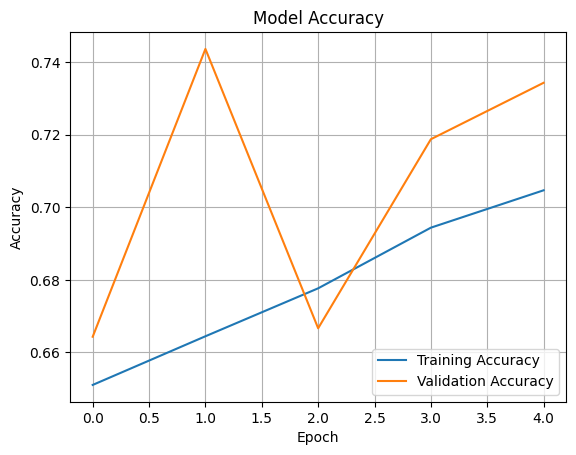

In [ ]:
# Step 14: Plot Accuracy and Loss Graphs
# Accuracy graph
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

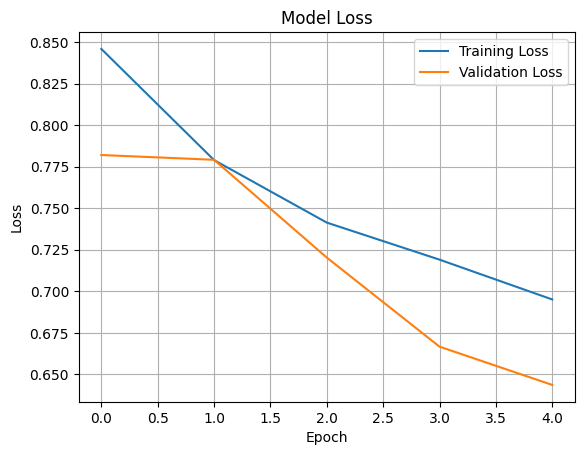

In [ ]:
# Loss graph
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()